In [73]:
import numpy as np
import minterpy as mp
import minterpy_integration as mint
import scipy.special as special
from math import ceil
from minterpy_integration.pointsandweights import point_generator
from minterpy_integration.utils import cartesian_product

In [74]:
def monomial_integral_cheb1st(exponents):
    cond = exponents>0
    term = np.ones(exponents.shape)*np.pi
    term[cond] = np.sqrt(np.pi)/exponents[cond] * ((-1)**exponents[cond] + 1)*special.gamma((exponents[cond] + 1)/2)/special.gamma(exponents[cond]/2)
    return np.prod(term,axis = 0)

def monomial_integral_cheb2nd(exponents):
    term = np.sqrt(np.pi)/4*((-1)**exponents + 1)*special.gamma((exponents + 1)/2)/special.gamma(exponents/2+2)
    return np.prod(term, axis = 0)

In [75]:
spatial_dimension = 2
poly_degree = 10
lp_degree = 2

In [76]:
k = int(ceil((poly_degree-1)/2))  

In [77]:
points_1d, weights_1d = point_generator('cheb1', k, True)

In [78]:
#point_generator('cheb1', k, False)

In [79]:
points_md = cartesian_product(*(points_1d,)* spatial_dimension)
weights_md = cartesian_product(*(weights_1d,)* spatial_dimension).prod(axis=-1)




In [80]:
np.savetxt('cheby_points_2d.csv', points_md, delimiter=',')
np.savetxt('cheby_weights_2d.csv', weights_md, delimiter=',')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev_L3
import polynomial_nets as pn
import poly_utils as ut 

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_LU, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

import uqtestfuns as uqtf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from Cuda import DeviceDataLoader

import torchquad
from torchquad import MonteCarlo, VEGAS, set_up_backend


/home/ashish-razer/Programs/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class Legendre(nn.Module):
    def __init__(self, degree, d, k, o):
        super(Legendre, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.T0 = nn.Parameter(nn.Linear(k, 1).weight.to(torch.float32)[0])
        for i in range(1, self.degree + 1):
            setattr(self, 'T{}'.format(i), nn.Linear(self.input_dimension, self.rank, bias=False)) 

        self.layer_C = nn.Linear(self.rank, self.output_dimension, bias = False)


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out0 = self.T0
        out1 = self.T1(z)
        out_list = [out0] + [out1]
        for i in range(2, self.degree + 1, 2):
            out0 = ((2*i - 1)/(i))*getattr(self, 'T{}'.format(i))(z) * out1 - ((i - 1)/(i))*out0
            out_list = out_list + [out0]
            if i == self.degree:
                x = self.layer_C(out_list[self.degree])
                return x
            else:
                j = i + 1
                out1 = ((2*j - 1)/(j))*getattr(self, 'T{}'.format(i + 1))(z) * out0 - ((j - 1)/(j))*out1
                out_list = out_list + [out1]
        x = self.layer_C(out_list[self.degree])
        return x


In [ ]:
def Norm_param(k, d):
    P = abs(nn.Linear(d, k, bias = False).weight.detach().to(torch.float32))
    P_sum = torch.sum(P, dim=1)
    P_norm = P/P_sum.reshape(-1,1)
    return P_norm

In [ ]:
def Norm_param2(k, d):
    P = torch.ones(k,d)
    P_sum = torch.sum(P, dim=1)
    P_norm = P/P_sum.reshape(-1,1)
    return P_norm

In [ ]:
class Legendre_test(nn.Module):
    def __init__(self, degree, d, k, o):
        super(Legendre_test, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.T0 = nn.Parameter(torch.ones(k))
        for i in range(1, self.degree + 1):
            setattr(self, 'T{}'.format(i), nn.Parameter(Norm_param2(k,d)))

        self.layer_C = nn.Parameter(torch.ones(self.output_dimension, self.rank))


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out0 = self.T0
        out1 = torch.matmul(z, (self.T1).T)
        out_list = [out0] + [out1]
        for i in range(2, self.degree + 1, 2):
            out0 = torch.matmul(z, ((2*i - 1)/(i))*getattr(self, 'T{}'.format(i)).T) * out1 - ((i - 1)/(i))*out0
            out_list = out_list + [out0]
            if i == self.degree:
                x = torch.matmul(out_list[self.degree], self.layer_C.T)
                return x
            else:
                j = i + 1
                out1 = torch.matmul(z, ((2*j - 1)/(j))*getattr(self, 'T{}'.format(i + 1)).T) * out0 - ((j - 1)/(j))*out1
                out_list = out_list + [out1]
        x = torch.matmul(out_list[self.degree], self.layer_C.T)
        return x

In [ ]:
class Chebyshev_test(nn.Module):
    def __init__(self, degree, d, k, o):
        super(Chebyshev, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.T0 = nn.Parameter(torch.ones(k))
        for i in range(1, self.degree + 1):
            setattr(self, 'T{}'.format(i), nn.Parameter(Norm_param(self.rank, self.input_dimension))) 

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out0 = self.T0
        out1 = self.T1(z)
        out_list = [out0] + [out1]
        for i in range(2, self.degree + 1, 2):
            out0 = getattr(self, 'T{}'.format(i))(z) * 2 * out1 - out0
            out_list = out_list + [out0]
            if i == self.degree:
                x = self.layer_C(out_list[self.degree])
                return x
            else:
                out1 = getattr(self, 'T{}'.format(i + 1))(z) * 2 * out0 - out1
                out_list = out_list + [out1]
        x = self.layer_C(out_list[self.degree])
        return x


In [ ]:
np.loadtxt('points_md.csv', delimiter=',')
np.loadtxt('weights_md.csv', delimiter=',').dtype

dtype('float64')

In [ ]:
RANK = 1
DEGREE1 = 2
DEGREE2 = 4
IN_DIM = 2
OUT_DIM = 1

In [ ]:
#set_up_backend("torch", data_type="float32")
#mc = MonteCarlo()
#vegas = VEGAS()

In [ ]:
points_md = torch.from_numpy(np.float32(np.loadtxt('points_md.csv', delimiter=','))).reshape(-1,IN_DIM)
weights_md = torch.from_numpy(np.float32(np.loadtxt('weights_md.csv', delimiter=','))).reshape(-1)

In [ ]:
Leg_1 = Legendre_test(DEGREE1, IN_DIM, RANK, OUT_DIM)
Leg_2 = Legendre_test(DEGREE2, IN_DIM, RANK, OUT_DIM)

In [ ]:
#Leg_1 = pn.Chebyshev(DEGREE1, IN_DIM, RANK, OUT_DIM)
#Leg_2 = pn.Chebyshev(DEGREE2, IN_DIM, RANK, OUT_DIM)

In [ ]:
def f(x):
    return Leg_1(x) * Leg_2(x)

In [ ]:
#integral_value = vegas.integrate(f, dim=2, N=10000, integration_domain=[[-1, 1], [-1, 1]], backend="torch",)
#print(integral_value)

In [ ]:
Leg_1.T2

Parameter containing:
tensor([[0.5000, 0.5000]], requires_grad=True)

In [ ]:
one = torch.ones(1,IN_DIM)

In [ ]:
torch.dot(Leg_1(points_md)[:,0] * Leg_2(points_md)[:,0], weights_md)

tensor(-0.0590, grad_fn=<DotBackward0>)

In [ ]:
torch.dot(Leg_1(points_md)[:,0] , weights_md)

tensor(-2.2352e-08, grad_fn=<DotBackward0>)

In [ ]:
torch.dot(Leg_2(points_md)[:,0] , weights_md)

tensor(-0.0972, grad_fn=<DotBackward0>)

In [ ]:
if IN_DIM == 2:
    input = torch.linspace(-1, 1, 100)
    X, Y = torch.meshgrid(input, input)
    grid = torch.stack((X.reshape(-1), Y.reshape(-1)), dim=1).reshape(-1, 2)
    out = Leg_1(grid)

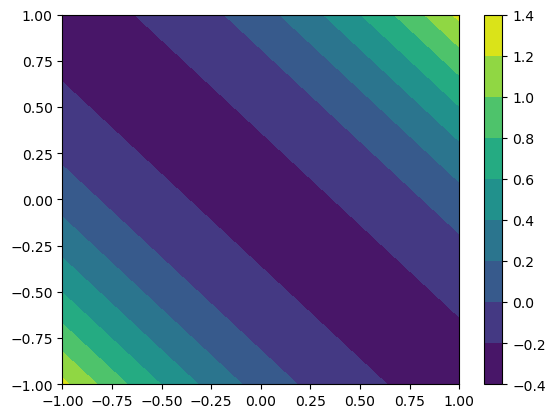

In [ ]:
if IN_DIM == 2:
    out.detach().numpy().reshape(100,100)
    cs = plt.contourf(X.detach().numpy(), Y.detach().numpy(), out.detach().numpy().reshape(100,100))
    cbar = plt.colorbar(cs)

In [ ]:
if IN_DIM == 1:

    #plt.plot(input.numpy(), (Leg_1(input)/Leg_1(one))[:,0].detach().numpy())
    plt.plot(input.numpy(), Leg_2(input)[:,0].detach().numpy())

    plt.plot(input.numpy(), Leg_1(input)[:,0].detach().numpy())
    #plt.plot(input.numpy(), Leg_2(input)[:,0].detach().numpy() * Leg_1(input)[:,0].detach().numpy())
    #plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.grid()

In [ ]:
P1 = abs(nn.Linear(8, 10, bias = False).weight.detach().to(torch.float32))

In [ ]:
P1_sum = torch.sum(P1, dim=1)

In [ ]:
P1_norm = P1/P1_sum.reshape(-1,1)

In [ ]:
torch.sum(P1_norm, dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [ ]:
torch.sum(P1, dim=1)

tensor([1.0260, 1.3380, 1.5592, 1.5940, 1.0042, 1.3331, 1.0346, 0.8181, 1.2415,
        0.8901])

In [ ]:
def Norm_param(k, d):
    P = abs(nn.Linear(d, k, bias = False).weight.detach().to(torch.float32))
    P_sum = torch.sum(P, dim=1)
    P_norm = P/P_sum.reshape(-1,1)
    return P_norm